In [1]:
require("ggplot2")
require("glmnet")
require("DAAG")
#install.packages('GGally', repos='http://cran.us.r-project.org')
#install.packages('glmnet', repos='http://cran.us.r-project.org')
data_body<-read.csv("BodyFat.csv")
density=data_body$DENSITY
data_body=data_body[,-c(1,3)]#delete the ID and density

Loading required package: ggplot2
Loading required package: glmnet
Warning message:
"package 'glmnet' was built under R version 3.4.3"Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-13

Loading required package: DAAG
Warning message:
"package 'DAAG' was built under R version 3.4.3"Loading required package: lattice


`geom_smooth()` using method = 'loess'


`geom_smooth()` using method = 'loess'


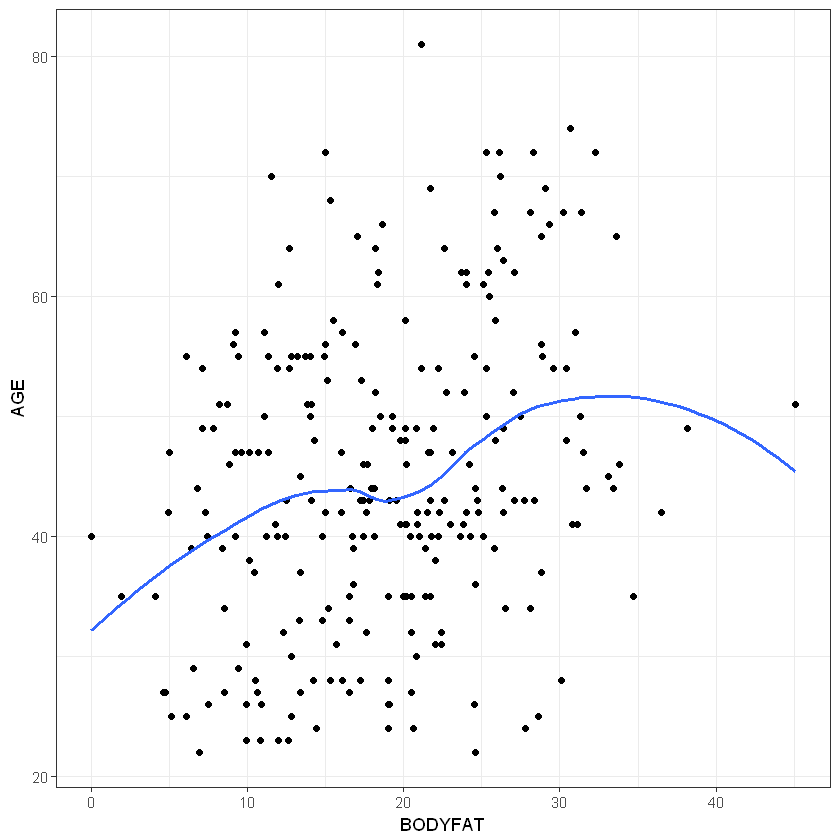

`geom_smooth()` using method = 'loess'


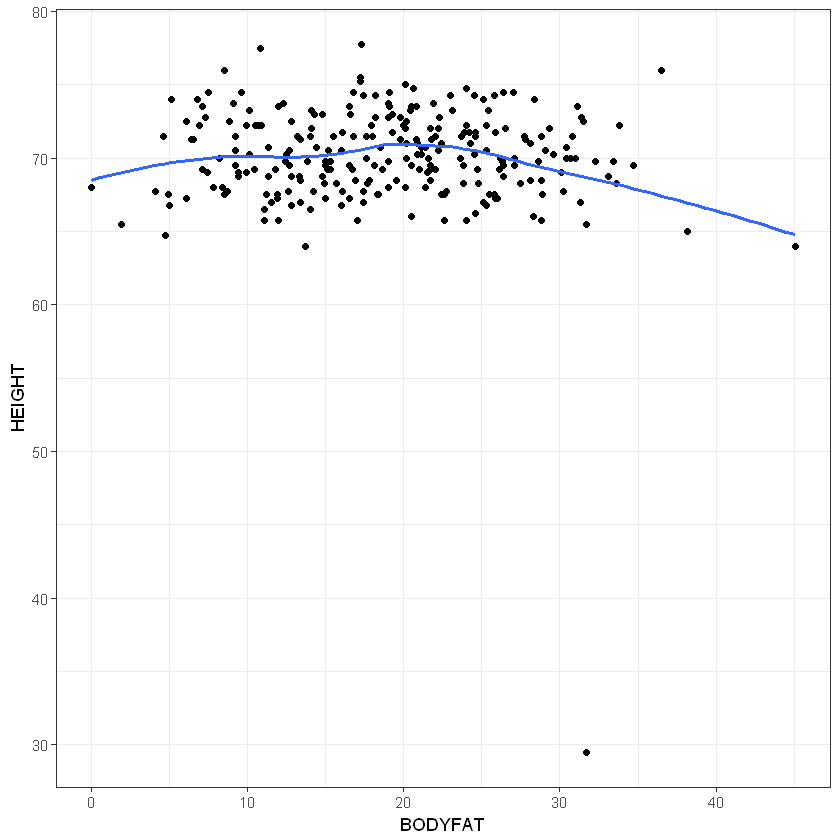

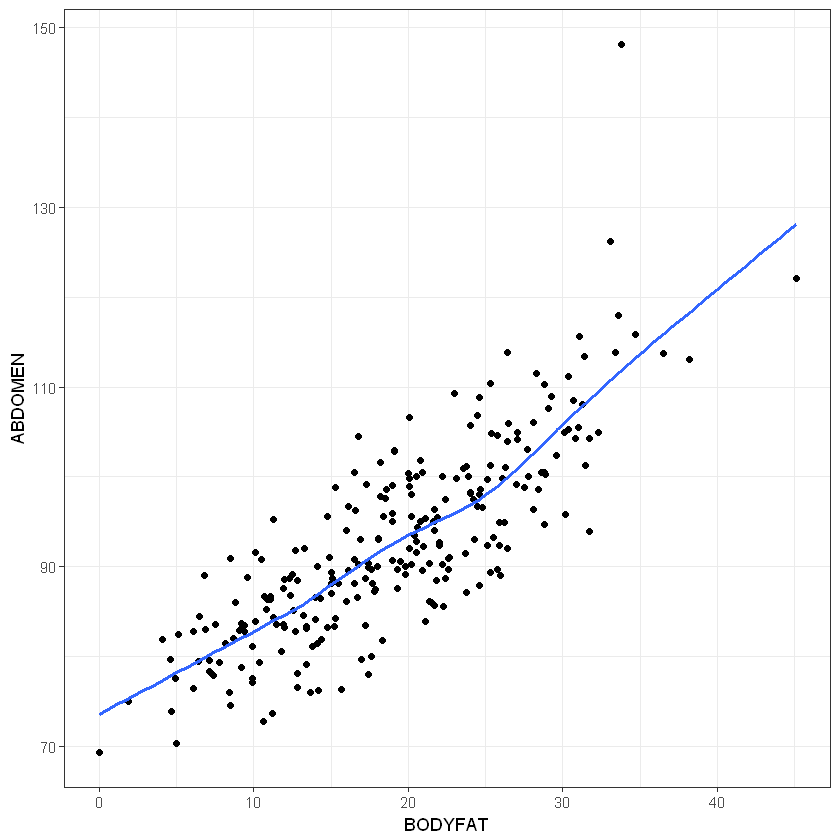

In [2]:
#### Step0:Select the model
ggplot(data = data_body) + 
  geom_point(mapping = aes(x = BODYFAT, y = AGE))+
  geom_smooth(mapping = aes(x = BODYFAT, y = AGE),se=FALSE)+ theme_bw()

ggplot(data = data_body) + 
  geom_point(mapping = aes(x = BODYFAT, y = WEIGHT))+
  geom_smooth(mapping = aes(x = BODYFAT, y = WEIGHT),se=FALSE)+ theme_bw()

ggplot(data = data_body) + 
  geom_point(mapping = aes(x = BODYFAT, y = HEIGHT))+
  geom_smooth(mapping = aes(x = BODYFAT, y = HEIGHT),se=FALSE)+ theme_bw()

ggplot(data = data_body) + 
  geom_point(mapping = aes(x = BODYFAT, y = ABDOMEN))+
  geom_smooth(mapping = aes(x = BODYFAT, y = ABDOMEN),se=FALSE)+ theme_bw()
#Interpretation: Based on these plots, we think that the BODYFAT has the linear relationship with the other given variables except the HEIGHT,
#thus, we choose the linear regression model

In [3]:
#### Step1:Pro-precess the data
#(1) delete the "ridiculous" point
data_body[182,]
values=495/density[182]-450
cat(sep="","body fat(according to the formula)=",values)
#Interpretation: we notice that the 182nd has bodyfat=0;and we calculate the body fat with the density formula and the result is negative, 
#which is meaning less, thus we delete it.
data_body=data_body[-which(data_body$BODYFAT==0),]#exclude 182nd

,BODYFAT,AGE,WEIGHT,HEIGHT,ADIPOSITY,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
182,0,40,118.5,68,18.1,33.8,79.3,69.4,85,47.2,33.5,20.2,27.7,24.6,16.5


body fat(according to the formula)=-3.611687

,BODYFAT,AGE,WEIGHT,HEIGHT,ADIPOSITY,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
42,31.7,44,205,29.5,29.9,36.6,106,104.3,115.5,70.6,42.5,23.7,33.6,28.7,17.4


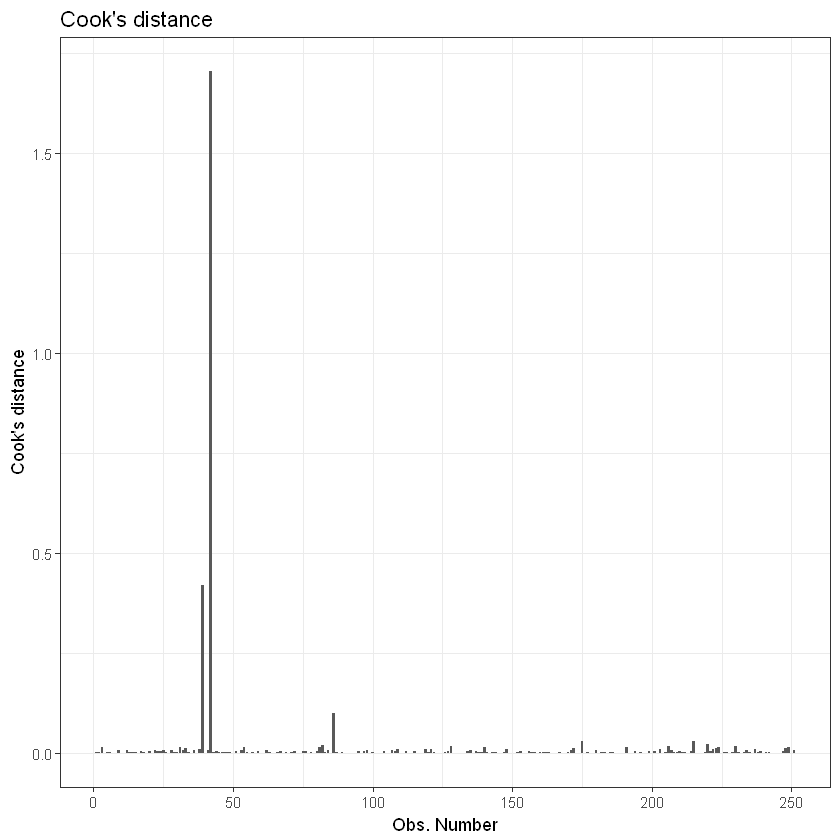

,BODYFAT,AGE,WEIGHT,HEIGHT,ADIPOSITY,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
39,33.8,46,363.15,72.25,48.9,51.2,136.2,148.1,147.7,87.3,49.1,29.6,45,29,21.4


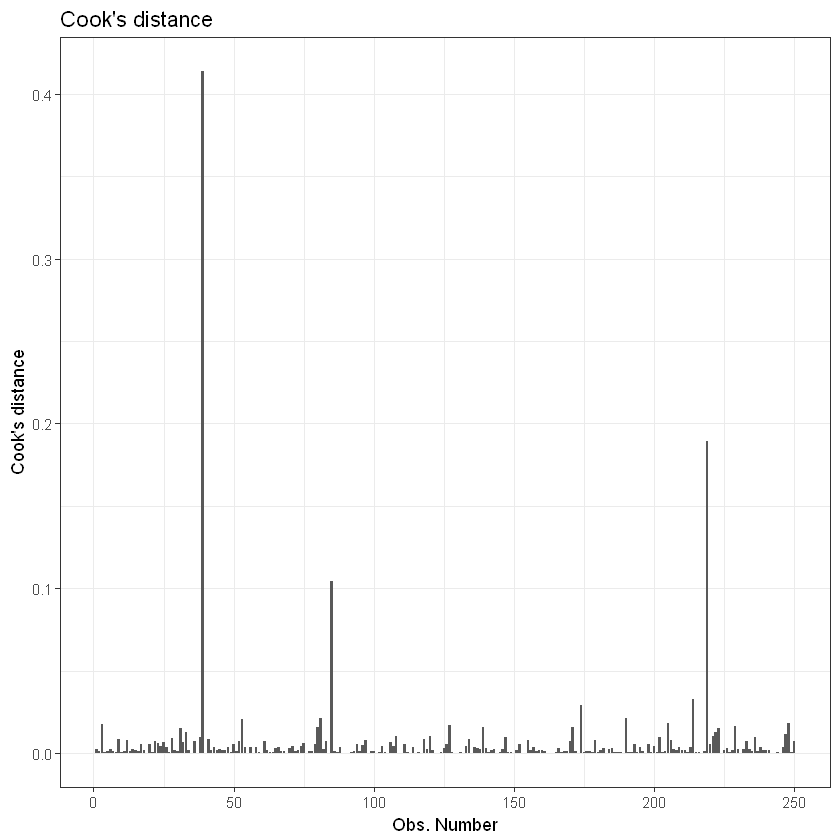

In [4]:
#(2) check the outliers
#Delete the records with Cook's distance greater than 2p/n step by step
model_all=lm(BODYFAT~.,data=data_body)
ggplot(model_all, aes(seq_along(.cooksd), .cooksd))+
  geom_bar(stat="identity", position="identity")+
  xlab("Obs. Number")+ylab("Cook's distance")+
  ggtitle("Cook's distance")+theme_bw()
data_body[which(cooks.distance(model_all)==max(cooks.distance(model_all))),]
#Interpretation: the 42nd observation has the biggest cook distance value and he is really short, thus we delete this record.
data_body=data_body[-which(cooks.distance(model_all)==max(cooks.distance(model_all))),]

model_all=lm(BODYFAT~.,data=data_body)
ggplot(model_all, aes(seq_along(.cooksd), .cooksd))+
  geom_bar(stat="identity", position="identity")+
  xlab("Obs. Number")+ylab("Cook's distance")+
  ggtitle("Cook's distance")+theme_bw()
data_body[which(cooks.distance(model_all)==max(cooks.distance(model_all))),]
#Interpretation: the 39th observation has the biggest cook distance value and he is really heavy, thus we delete this record.
data_body=data_body[-which(cooks.distance(model_all)==max(cooks.distance(model_all))),]

In [5]:
#### Step2: Select the variables
#(1) First we use forward AIC standard
null=lm(BODYFAT~1, data=data_body)
select = step(null, scope=list(lower=null, upper=model_all), direction="forward",trace=0)
summary(select)

#(2) Secondly, we try the BIC.
null=lm(BODYFAT~1, data=data_body)
select = step(null, scope=list(lower=null, upper=model_all), direction="forward",trace=0,k = log(249))
summary(select)


Call:
lm(formula = BODYFAT ~ ABDOMEN + WEIGHT + WRIST + BICEPS + AGE, 
    data = data_body)

Residuals:
    Min      1Q  Median      3Q     Max 
-9.4993 -2.6962 -0.2706  3.1972  8.7266 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -23.71669    7.06737  -3.356 0.000918 ***
ABDOMEN       0.83796    0.06314  13.272  < 2e-16 ***
WEIGHT       -0.08539    0.03055  -2.795 0.005607 ** 
WRIST        -1.65891    0.45052  -3.682 0.000285 ***
BICEPS        0.27709    0.13981   1.982 0.048619 *  
AGE           0.03881    0.02615   1.484 0.139047    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 3.95 on 243 degrees of freedom
Multiple R-squared:  0.7356,	Adjusted R-squared:  0.7301 
F-statistic: 135.2 on 5 and 243 DF,  p-value: < 2.2e-16



Call:
lm(formula = BODYFAT ~ ABDOMEN + WEIGHT + WRIST, data = data_body)

Residuals:
    Min      1Q  Median      3Q     Max 
-9.0322 -2.9552 -0.4383  3.0110  9.1926 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -23.99356    6.23603  -3.848 0.000152 ***
ABDOMEN       0.88476    0.05108  17.320  < 2e-16 ***
WEIGHT       -0.08678    0.02234  -3.885 0.000132 ***
WRIST        -1.28161    0.40274  -3.182 0.001650 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 3.981 on 245 degrees of freedom
Multiple R-squared:  0.7292,	Adjusted R-squared:  0.7259 
F-statistic: 219.9 on 3 and 245 DF,  p-value: < 2.2e-16


14 x 1 sparse Matrix of class "dgCMatrix"
                   s0
AGE        0.04109122
WEIGHT     .         
HEIGHT    -0.22420552
ADIPOSITY  0.16566475
NECK       .         
CHEST      .         
ABDOMEN    0.56930484
HIP        .         
THIGH      .         
KNEE       .         
ANKLE      .         
BICEPS     .         
FOREARM    .         
WRIST     -0.94621223

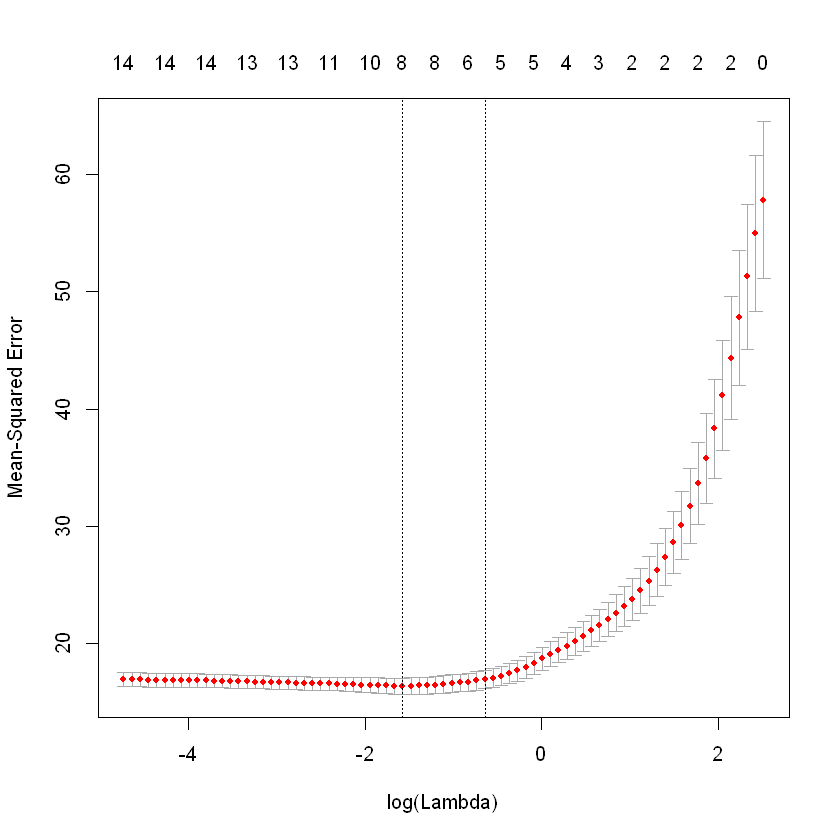

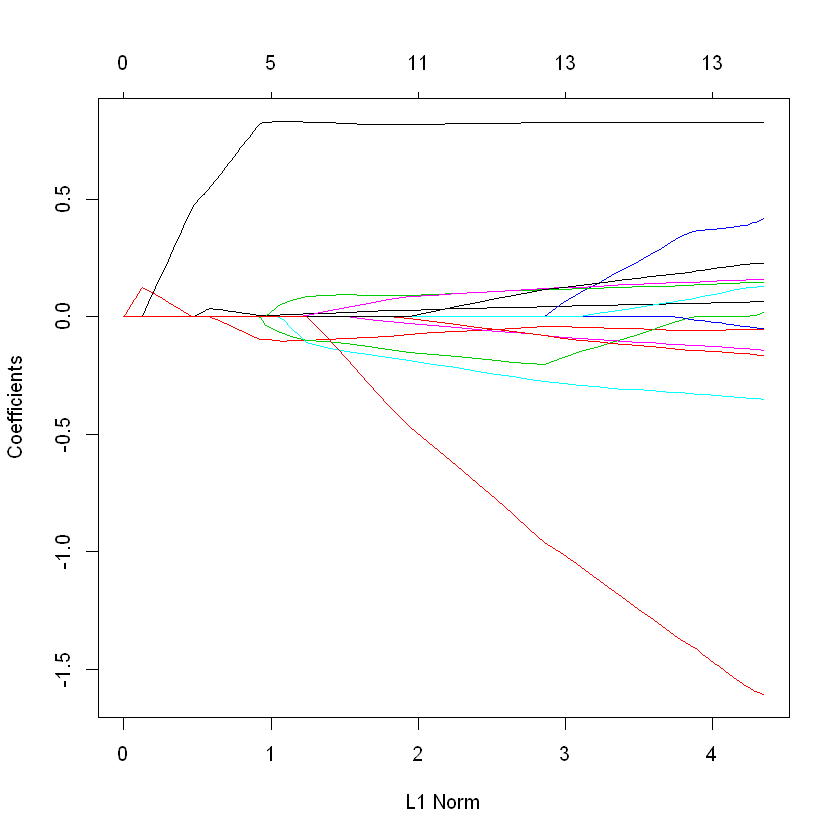

In [6]:
#(3) then we switch to the elastic net model
alpha = 0.5#hyper-parameter
cv1 <- cv.glmnet(x = as.matrix(data_body[,2:15]),y = data_body[,1], nfold = 5, type.measure = "deviance", alpha = 0.5)
plot(cv1)

md1 <- glmnet(x = as.matrix(data_body[,2:15]),y = data_body[,1], lambda = cv1$lambda.1se, alpha = 0.5)
md1$beta
alpha = 0.5
lm = glmnet(x = as.matrix(data_body[,2:15]),y = data_body[,1],alpha = alpha,standardize = F)
plot(lm)

In [7]:
#pick weight and abdomen as our final variables
lm1 = lm(BODYFAT~WEIGHT+ABDOMEN+WRIST,data = data_body)
vif(lm1)#acceptable
summary(lm1)#R^2 0.72

WEIGHT ABDOMEN   WRIST 
 5.6178  4.1857  2.0988


Call:
lm(formula = BODYFAT ~ WEIGHT + ABDOMEN + WRIST, data = data_body)

Residuals:
    Min      1Q  Median      3Q     Max 
-9.0322 -2.9552 -0.4383  3.0110  9.1926 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -23.99356    6.23603  -3.848 0.000152 ***
WEIGHT       -0.08678    0.02234  -3.885 0.000132 ***
ABDOMEN       0.88476    0.05108  17.320  < 2e-16 ***
WRIST        -1.28161    0.40274  -3.182 0.001650 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 3.981 on 245 degrees of freedom
Multiple R-squared:  0.7292,	Adjusted R-squared:  0.7259 
F-statistic: 219.9 on 3 and 245 DF,  p-value: < 2.2e-16


`geom_smooth()` using method = 'loess'


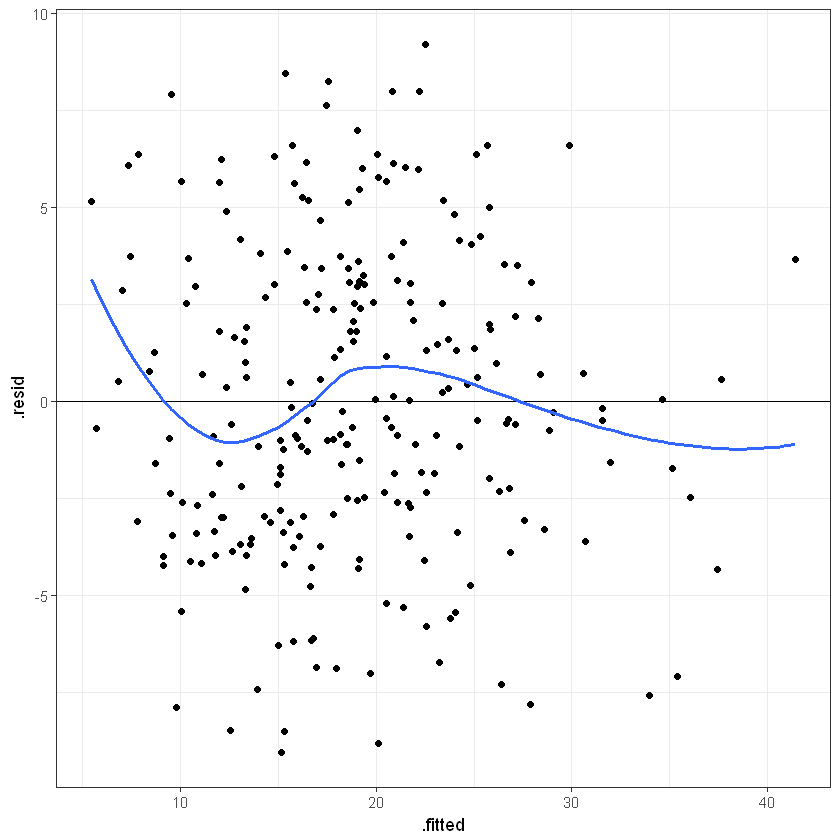

`geom_smooth()` using method = 'loess'


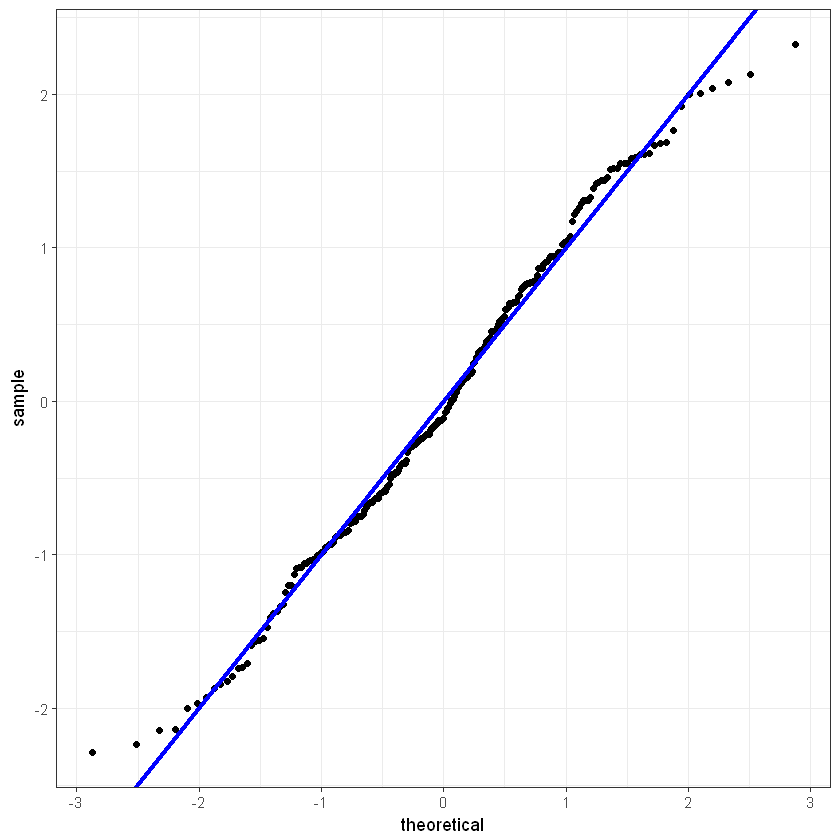

`geom_smooth()` using method = 'loess'


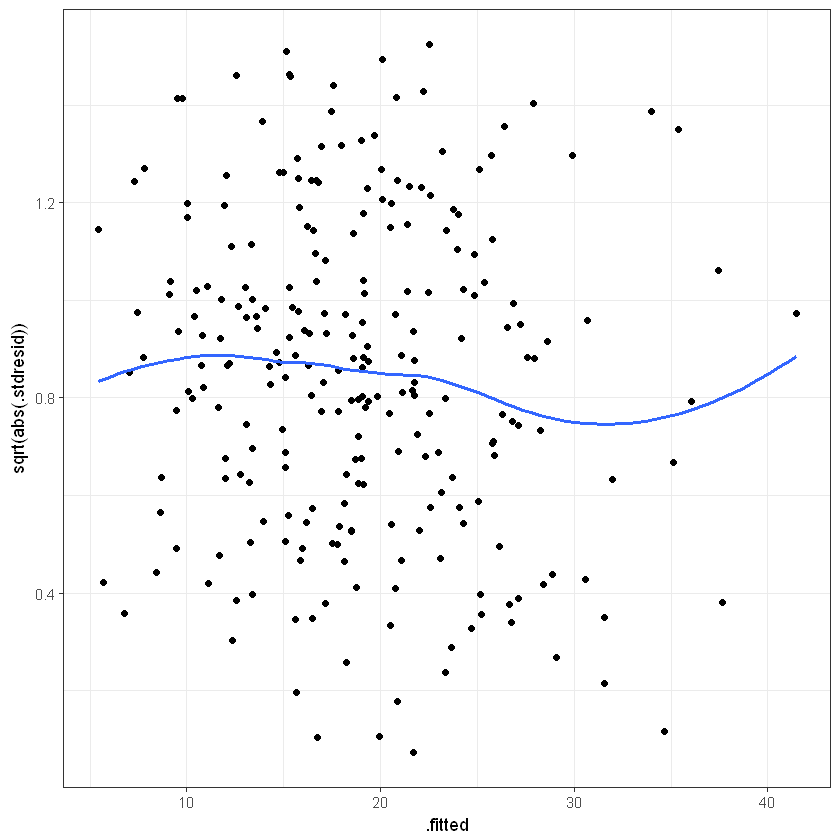

Warning message:
"The plyr::rename operation has created duplicates for the following name(s): (``)"

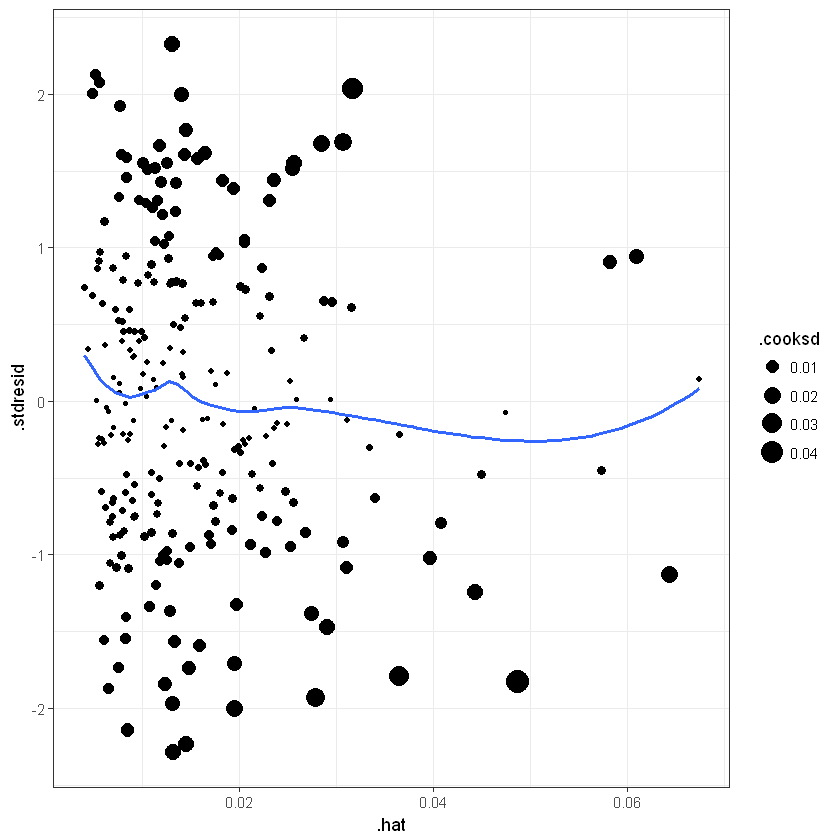

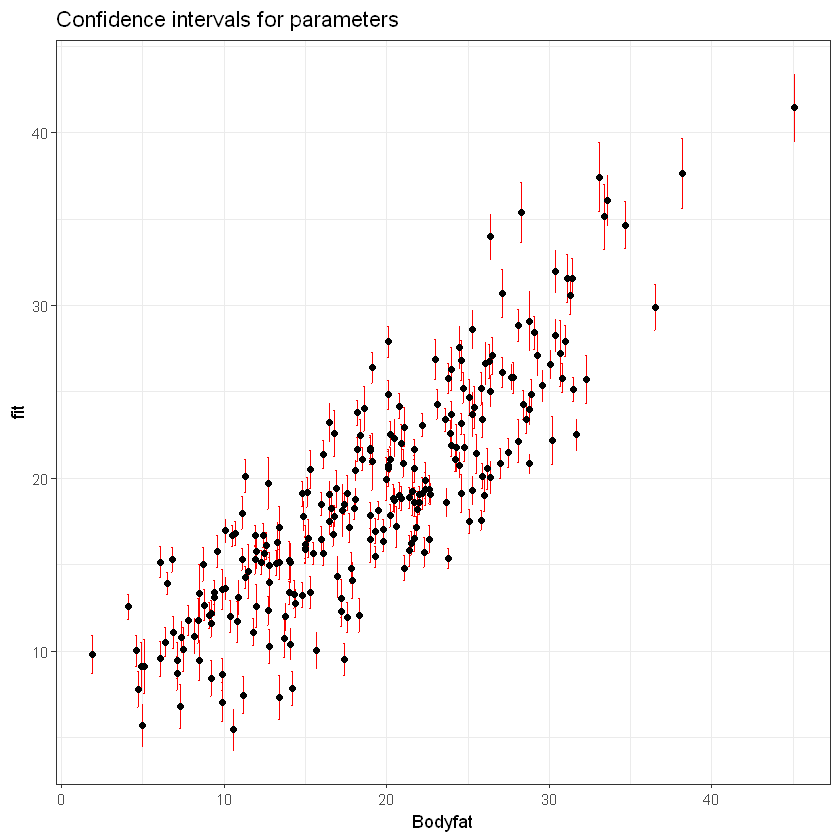

In [9]:
## Diagnostic and Prediction
ggplot(lm1, aes(.fitted, .resid)) +
  geom_point() +
  geom_hline(yintercept = 0) +
  geom_smooth(se = FALSE) + theme_bw()

ggplot(lm1) +
  stat_qq(aes(sample = .stdresid)) +
  geom_abline(color="blue",cex=1.2) + theme_bw()

ggplot(lm1, aes(.fitted, sqrt(abs(.stdresid)))) +
  geom_point() +
  geom_smooth(se = FALSE)+ theme_bw()

ggplot(lm1, aes(.hat, .stdresid)) +
  geom_point(aes(size = .cooksd)) +
  geom_smooth(se = FALSE) + theme_bw()        

# Calculate the confidence interval
predCI <- predict(lm1, interval = 'confidence', level = 0.95)
predmatrix = data.frame(Bodyfat = data_body$BODYFAT,fit=predCI[,1],lwr=predCI[,2],upr=predCI[,3])
# Plot using ggplot
ggplot(predmatrix, aes(Bodyfat, fit,lwr,upr)) + theme_bw()+
  ggtitle('Confidence intervals for parameters')+
  geom_errorbar(aes(ymin=lwr, ymax=upr), colour="red", width=.1)+
  geom_point(data=predmatrix, aes(x = Bodyfat, y = fit)) 